In [1]:
import argparse, os, shutil, time, warnings
from datetime import datetime
from pathlib import Path
import numpy as np
import sys

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# import models
from fp16util import network_to_half, set_grad, copy_in_params

# model_names = sorted(name for name in models.__dict__
#                      if name.islower() and not name.startswith("__")
#                      and callable(models.__dict__[name]))
#print(model_names)

In [2]:
import matplotlib.pyplot as plt

In [3]:
def get_parser():
    parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
    parser.add_argument('data', metavar='DIR', help='path to dataset')
    parser.add_argument('--save-dir', type=str, default=Path.cwd(), help='Directory to save logs and models.')
    parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet50')
    # parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet18',
    #                     choices=model_names,
    #                     help='model architecture: ' +
    #                     ' | '.join(model_names) +
    #                     ' (default: resnet18)')
    parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                        help='number of data loading workers (default: 4)')
    parser.add_argument('--epochs', default=45, type=int, metavar='N',
                        help='number of total epochs to run')
    parser.add_argument('--warmup', default=0, type=int, metavar='N',
                        help='number of additional epochs to warmup')
    parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                        help='manual epoch number (useful on restarts)')
    parser.add_argument('-b', '--batch-size', default=256, type=int,
                        metavar='N', help='mini-batch size (default: 256)')
    parser.add_argument('--lr', '--learning-rate', default=0.4, type=float,
                        metavar='LR', help='initial learning rate')
    parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
    parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                        metavar='W', help='weight decay (default: 1e-4)')
    parser.add_argument('--print-freq', '-p', default=10, type=int,
                        metavar='N', help='print frequency (default: 10)')
    parser.add_argument('--resume', default='', type=str, metavar='PATH',
                        help='path to latest checkpoint (default: none)')
    parser.add_argument('--small', action='store_true', help='start with smaller images')
    parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                        help='evaluate model on validation set')
    parser.add_argument('--pretrained', dest='pretrained', action='store_true', help='use pre-trained model')
    parser.add_argument('--fp16', action='store_true', help='Run model fp16 mode.')
    parser.add_argument('--dp', action='store_true', help='Run model fp16 mode.')
    parser.add_argument('--sz',       default=224, type=int, help='Size of transformed image.')
    parser.add_argument('--decay-int', default=30, type=int, help='Decay LR by 10 every decay-int epochs')
    parser.add_argument('--loss-scale', type=float, default=1,
                        help='Loss scaling, positive power of 2 values can improve fp16 convergence.')
    parser.add_argument('--prof', dest='prof', action='store_true', help='Only run a few iters for profiling.')

    parser.add_argument('--distributed', action='store_true', help='Run distributed training')
    parser.add_argument('--dist-url', default='file://sync.file', type=str,
                        help='url used to set up distributed training')
    parser.add_argument('--dist-backend', default='nccl', type=str, help='distributed backend')
    parser.add_argument('--local_rank', default=0, type=int,
                        help='Used for multi-process training. Can either be manually set ' +
                        'or automatically set by using \'python -m multiproc\'.')
    return parser

cudnn.benchmark = True
args = get_parser().parse_args(['/home/paperspace/data/imagenet'])
if args.local_rank > 0: sys.stdout = open(f'{args.save_dir}/GPU_{args.local_rank}.log', 'w')

In [4]:
def get_loaders(traindir, valdir, bs, val_bs=None, use_val_sampler=True, min_scale=0.08):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor_tfm = [transforms.ToTensor(), normalize]
    val_bs = val_bs or bs
    train_dataset = datasets.ImageFolder(
        traindir, transforms.Compose([
            transforms.RandomResizedCrop(args.sz, scale=(min_scale, 1.0)),
            transforms.RandomHorizontalFlip(),
        ] + tensor_tfm))
    val_dataset = datasets.ImageFolder(
        valdir, transforms.Compose([
            transforms.Resize(int(args.sz*1.14)),
            transforms.CenterCrop(args.sz),
        ] + tensor_tfm))

    train_sampler = (torch.utils.data.distributed.DistributedSampler(train_dataset) if args.distributed else None)
    val_sampler = (torch.utils.data.distributed.DistributedSampler(val_dataset) if args.distributed else None)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True, sampler=train_sampler)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=val_bs, shuffle=False,
        num_workers=args.workers, pin_memory=True, sampler=val_sampler if use_val_sampler else None)

    return train_loader,val_loader,train_sampler,val_sampler

## Validation dataset

In [17]:
from torch.utils.data.sampler import Sampler
import torchvision

In [18]:
sz = 128
batch_size = 128
valdir = os.path.join(args.data+'-160', 'val')

In [69]:
import pickle

In [73]:
pickle.dump(idx_ar, open('idxar.p', 'wb'))

In [75]:
idx_ar = pickle.load(open('idxar.p', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'idxdfar.p'

In [76]:
import os.path
os.path.isfile('idxar.p') 

True

In [ ]:
if 

In [68]:
idx_ar

[(0, 1.33125),
 (1, 1.33125),
 (2, 1.33125),
 (3, 1.33125),
 (4, 1.33125),
 (5, 1.33125),
 (6, 1.33125),
 (7, 1.33125),
 (8, 1.33125),
 (9, 1.33125),
 (10, 1.25),
 (11, 1.16875),
 (12, 1.33125),
 (13, 1.33125),
 (14, 1.33125),
 (15, 1.33125),
 (16, 1.33125),
 (17, 1.33125),
 (18, 1.33125),
 (19, 1.33125),
 (20, 1.33125),
 (21, 1.33125),
 (22, 1.33125),
 (23, 1.33125),
 (24, 1.33125),
 (25, 1.33125),
 (26, 1.33125),
 (27, 1.33125),
 (28, 1.33125),
 (29, 1.33125),
 (30, 1.33125),
 (31, 0.75117),
 (32, 1.33125),
 (33, 1.33125),
 (34, 1.33125),
 (35, 1.33125),
 (36, 1.33125),
 (37, 1.33125),
 (38, 1.33125),
 (39, 1.33125),
 (40, 1.33125),
 (41, 1.33125),
 (42, 1.33125),
 (43, 0.75117),
 (44, 1.33125),
 (45, 1.33125),
 (46, 1.33125),
 (47, 1.33125),
 (48, 1.33125),
 (49, 0.9816),
 (50, 1.0),
 (51, 1.33125),
 (52, 1.33125),
 (53, 1.33125),
 (54, 1.33125),
 (55, 1.33125),
 (56, 1.33125),
 (57, 1.0125),
 (58, 1.1375),
 (59, 1.30625),
 (60, 1.33125),
 (61, 0.9697),
 (62, 1.33125),
 (63, 1.33125

In [ ]:
np.save(idx_ar)

In [90]:
import os.path

def sort_ar(valdir):
    if os.path.isfile('sorted_idxar.p'): return pickle.load(open('sorted_idxar.p', 'rb'))
    val_dataset = datasets.ImageFolder(valdir)
    sizes = [img[0].size for img in val_dataset]
    idx_ar = [(i, round(s[0]/s[1], 5)) for i,s in enumerate(sizes)]
    sorted_idxar = sorted(idx_ar, key=lambda x: x[1])
    pickle.dump(sorted_idxar, open('sorted_idxar.p', 'wb'))
    return sorted_idxar

def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

def map_idx2ar(idx_ar_sorted, batch_size):
    ar_chunks = list(chunks(idx_ar_sorted, batch_size))
    idx2ar = {}
    for chunk in ar_chunks:
        idxs, ars = list(zip(*chunk))
        mean = round(np.mean(ars), 5)
        for idx in idxs:
            idx2ar[idx] = mean
    return idx2ar

In [91]:
class ValDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, ar_transform=None):
        super().__init__(root, transform, target_transform)
        self.ar_transform = ar_transform
    def __getitem__(self, index):
        path, target = self.imgs[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.ar_transform(sample, index)
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

class ARSampler(Sampler):
    def __init__(self, indices): self.indices = indices
    def __len__(self): return len(self.indices)
    def __iter__(self): return iter(self.indices)
    

class CropArTfm(object):
    def __init__(self, idx2ar, target_size):
        self.idx2ar, self.target_size = idx2ar, target_size
    def __call__(self, img, idx):
        target_ar = self.idx2ar[idx]
        if target_ar < 1: 
            w = int(self.target_size/target_ar)
            size = (w//8*8, self.target_size)
        else: 
            h = int(self.target_size*target_ar)
            size = (self.target_size, h//8*8)
        return torchvision.transforms.functional.center_crop(img, size)

In [92]:
def create_validation_set(valdir, batch_size, target_size, tensor_tfm, use_val_sampler, use_ar_sampler):
    idx_ar_sorted = sort_ar(valdir)
    idx_sorted, _ = zip(*idx_ar_sorted)
    idx2ar = map_idx2ar(idx_ar_sorted, batch_size)
    
    if use_ar_sampler:
        val_dataset = ValDataset(valdir, transforms.Compose(tensor_tfm), ar_transform=CropArTfm(idx2ar, target_size))
        val_sampler = ARSampler(idx_sorted)
        return val_dataset, val_sampler
    
    val_tfms = [transforms.Resize(int(args.sz*1.14)), transforms.CenterCrop(args.sz)] + tensor_tfm
    val_dataset = datasets.ImageFolder(valdir,  transforms.Compose(val_tfms))
    val_sampler = None
    if use_val_sampler and args.distributed:
        val_sampler = torch.utils.data.distributed.DistributedSampler(val_dataset)
    return val_dataset, val_sampler
    

In [93]:
def get_loaders(traindir, valdir, bs, val_bs=None, use_val_sampler=True, use_ar_sampler=False, min_scale=0.08):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    tensor_tfm = [transforms.ToTensor(), normalize]
    
    train_dataset = datasets.ImageFolder(
        traindir, transforms.Compose([
            transforms.RandomResizedCrop(args.sz, scale=(min_scale, 1.0)),
            transforms.RandomHorizontalFlip(),
        ] + tensor_tfm))
    train_sampler = (torch.utils.data.distributed.DistributedSampler(train_dataset) if args.distributed else None)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=(train_sampler is None),
        num_workers=args.workers, pin_memory=True, sampler=train_sampler)

    val_bs = val_bs or bs
    val_dataset, val_sampler = create_validation_set(valdir, val_bs, args.sz, tensor_tfm, use_val_sampler, use_ar_sampler)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=val_bs, shuffle=False,
        num_workers=args.workers, pin_memory=True, sampler=val_sampler)

    return train_loader,val_loader,train_sampler,val_sampler

In [ ]:

    if args.small:
        traindir = os.path.join(args.data+'-sz/160', 'train')
        valdir = os.path.join(args.data+'-sz/160', 'validation')
        args.sz = 128
    else:
        # traindir = os.path.join(args.data+'-sz/320', 'train') # (AS) WARNING: added 320
        # valdir = os.path.join(args.data+'-sz/320', 'validation') # (AS) WARNING: added 320
        traindir = os.path.join(args.data, 'train')
        valdir = os.path.join(args.data, 'validation')
        args.sz = 224

In [94]:
traindir = os.path.join(args.data+'-160', 'train')
valdir = os.path.join(args.data+'-160', 'val')

In [96]:
train_loader,val_loader,train_sampler,val_sampler = get_loaders(traindir, valdir, bs=args.batch_size, use_val_sampler=False, use_ar_sampler=True)

In [97]:
it = iter(val_loader)

In [65]:
x,y = next(it)

In [66]:
x.shape

torch.Size([256, 3, 408, 224])

In [10]:
sizes = [img[0].size for img in val_dataset]
idx_ar = [(i, round(s[0]/s[1], 5)) for i,s in enumerate(sizes)]
idx_ar_sort = sorted(idx_ar, key=lambda x: x[1])

In [12]:
ar_chunks = list(chunks(idx_ar_sort, batch_size))
idx2ar = {}
for chunk in ar_chunks:
    idxs, ars = list(zip(*chunk))
    mean = round(np.mean(ars), 5)
    for idx in idxs:
        idx2ar[idx] = mean
    

In [56]:
from torchvision.datasets.folder import default_loader

In [114]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
tensor_tfm = [transforms.ToTensor()]

val_dataset = ValDataset(
    valdir, transforms.Compose(tensor_tfm), ar_transform=CropArTfm(idx2ar, sz))

# val_dataset = ValDataset(
#     valdir, transforms.Compose([
#         transforms.Resize(int(sz*1.14)),
#         transforms.CenterCrop(sz),
#     ] + tensor_tfm), ar_transform=CropArTfm(idx2ar, sz))

# val_sampler = (torch.utils.data.distributed.DistributedSampler(val_dataset) if args.distributed else None)
val_bsampler = ARSampler(idx_sorted)
# val_bsampler = None

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=128,
    num_workers=1, pin_memory=True, sampler=val_bsampler)

In [115]:
it = iter(val_loader)

(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)
(262, 128)

(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)
(191, 128)

In [132]:
x,y = next(it)

In [133]:
x.shape

torch.Size([128, 3, 191, 128])

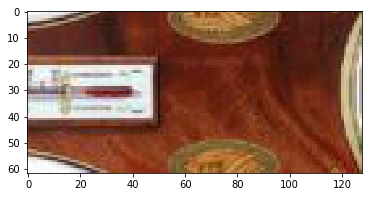

In [111]:
plt.imshow(x[3].cpu().numpy().T)

In [36]:
len(val_dataset)

50000

In [ ]:
val_dataset[31757][0].size

In [ ]:
ar2targ

In [ ]:
idxs, ars = list(zip(*ar_chunks[0]))

In [ ]:
np.mean(ars), idxs

In [ ]:
np.mean(ar_chunks[0])

In [ ]:
df = pd.DataFrame(data=ar)

In [ ]:
df.describe()

In [ ]:
sorted(ar)

In [ ]:
img.size

## Main method

In [ ]:
def main():
    print("~~epoch\thours\ttop1Accuracy\n")
    start_time = datetime.now()

    if args.distributed:
        torch.cuda.set_device(args.local_rank)
        dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url)
        print('Distributed: init_process_group success')

    if args.fp16: assert torch.backends.cudnn.enabled, "fp16 mode requires cudnn backend to be enabled."

    # create model
    # if args.pretrained: model = models.__dict__[args.arch](pretrained=True)
    # else: model = models.__dict__[args.arch]()
    # AS: force use resnet50 for now, until we figure out whether to upload model directory
    import resnet
    model = resnet.resnet50()

    print("Loaded model")

    model = model.cuda()
    n_dev = torch.cuda.device_count()
    if args.fp16: model = network_to_half(model)
    if args.distributed: model = nn.parallel.DistributedDataParallel(model, device_ids=[args.local_rank], output_device=args.local_rank)
    elif args.dp:
        model = nn.DataParallel(model)
        args.batch_size *= n_dev

    global param_copy
    if args.fp16:
        param_copy = [param.clone().type(torch.cuda.FloatTensor).detach() for param in model.parameters()]
        for param in param_copy: param.requires_grad = True
    else: param_copy = list(model.parameters())

    # define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(param_copy, args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    print("Defined loss and optimizer")

    best_prec1 = 0
    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            checkpoint = torch.load(args.resume, map_location = lambda storage, loc: storage.cuda(args.gpu))
            args.start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
        else: print("=> no checkpoint found at '{}'".format(args.resume))

    if args.small:
        traindir = os.path.join(args.data+'-sz/160', 'train')
        valdir = os.path.join(args.data+'-sz/160', 'validation')
        args.sz = 128
    else:
        # traindir = os.path.join(args.data+'-sz/320', 'train') # (AS) WARNING: added 320
        # valdir = os.path.join(args.data+'-sz/320', 'validation') # (AS) WARNING: added 320
        traindir = os.path.join(args.data, 'train')
        valdir = os.path.join(args.data, 'validation')
        args.sz = 224

    train_loader,val_loader,train_sampler,val_sampler = get_loaders(traindir, valdir, bs=args.batch_size, use_val_sampler=True)

    if args.evaluate: return validate(val_loader, model, criterion, epoch, start_time)

    print("Created data loaders")

    print("Begin training")
    for epoch in range(args.start_epoch, args.epochs+args.warmup):
        adjust_learning_rate(optimizer, epoch)
        if epoch==int(args.epochs*0.4+0.5)+args.warmup:
            # traindir = os.path.join(args.data+'-sz/320', 'train') # (AS) WARNING: added 320
            # valdir = os.path.join(args.data+'-sz/320', 'validation') # (AS) WARNING: added 320
            traindir = os.path.join(args.data, 'train')
            valdir = os.path.join(args.data, 'validation')
            args.sz = 224
            train_loader,val_loader,train_sampler,val_sampler = get_loaders(traindir, valdir, bs=args.bs)
        if epoch==int(args.epochs*0.92+0.5)+args.warmup:
            args.sz=288
            traindir = os.path.join(args.data, 'train')
            valdir = os.path.join(args.data, 'validation')
            train_loader,val_loader,train_sampler,val_sampler = get_loaders(
                traindir, valdir, bs=160, val_bs=128, use_val_sampler=True, min_scale=0.5)
        if epoch==args.epochs+args.warmup-2:
            args.sz=288
            traindir = os.path.join(args.data, 'train')
            valdir = os.path.join(args.data, 'validation')
            train_loader,val_loader,train_sampler,val_sampler = get_loaders(
                traindir, valdir, bs=160, val_bs=128, use_val_sampler=False, min_scale=0.5)

        # getting out of memory. Maybe we need to collect memory?
        import gc
        gc.collect()
        torch.cuda.empty_cache()

        if args.distributed:
            train_sampler.set_epoch(epoch)
            val_sampler.set_epoch(epoch)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            train(train_loader, model, criterion, optimizer, epoch)

        if args.prof: break
        prec1 = validate(val_loader, model, criterion, epoch, start_time)

        if args.local_rank == 0:
            is_best = prec1 > best_prec1
            best_prec1 = max(prec1, best_prec1)
            save_checkpoint({
                'epoch': epoch + 1, 'arch': args.arch, 'state_dict': model.state_dict(),
                'best_prec1': best_prec1, 'optimizer' : optimizer.state_dict(),
            }, is_best)

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every few epochs"""
    if   epoch<int(args.epochs*0.1)+args.warmup : lr = args.lr/(int(args.epochs*0.1)-epoch+args.warmup)
    elif epoch<int(args.epochs*0.47+0.5)+args.warmup: lr = args.lr/1
    elif epoch<int(args.epochs*0.78+0.5)+args.warmup: lr = args.lr/10
    elif epoch<int(args.epochs*0.95+0.5)+args.warmup: lr = args.lr/100
    else         : lr = args.lr/1000
    if (epoch < args.warmup) and (args.lr > 3.0): lr = lr/3 # even smaller lr for warmup
    for param_group in optimizer.param_groups: param_group['lr'] = lr


# item() is a recent addition, so this helps with backward compatibility.
def to_python_float(t):
    if hasattr(t, 'item'):
        return t.item()
    else:
        return t[0]

class data_prefetcher():
    def __init__(self, loader, prefetch=True):
        self.loader,self.prefetch = iter(loader),prefetch
        if prefetch:
            self.stream = torch.cuda.Stream()
            self.preload()

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loader)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def next(self):
        if not self.prefetch:
            input,target = next(self.loader)
            return input.cuda(async=True),target.cuda(async=True)

        torch.cuda.current_stream().wait_stream(self.stream)
        input = self.next_input
        target = self.next_target
        self.preload()
        return input, target


def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to train mode
    model.train()
    end = time.time()

    prefetcher = data_prefetcher(train_loader, prefetch=True)
    input, target = prefetcher.next()
    i = -1
    while input is not None:
        i += 1
        if args.prof and (i > 200): break
        # measure data loading time
        data_time.update(time.time() - end)

        input_var = Variable(input)
        target_var = Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))

        if args.distributed:
            reduced_loss = reduce_tensor(loss.data)
            prec1 = reduce_tensor(prec1)
            prec5 = reduce_tensor(prec5)
        else:
            reduced_loss = loss.data

        losses.update(to_python_float(reduced_loss), input.size(0))
        top1.update(to_python_float(prec1), input.size(0))
        top5.update(to_python_float(prec5), input.size(0))

        loss = loss*args.loss_scale
        # compute gradient and do SGD step

        if args.fp16:
            model.zero_grad()
            loss.backward()
            set_grad(param_copy, list(model.parameters()))

            if args.loss_scale != 1:
                for param in param_copy:
                    param.grad.data = param.grad.data/args.loss_scale

            optimizer.step()
            copy_in_params(model, param_copy)
            torch.cuda.synchronize()
        else:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)

        end = time.time()
        input, target = prefetcher.next()

        if args.local_rank == 0 and i % args.print_freq == 0 and i > 1:
            output = ('Epoch: [{0}][{1}/{2}]\t' \
                    + 'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t' \
                    + 'Data {data_time.val:.3f} ({data_time.avg:.3f})\t' \
                    + 'Loss {loss.val:.4f} ({loss.avg:.4f})\t' \
                    + 'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t' \
                    + 'Prec@5 {top5.val:.3f} ({top5.avg:.3f})').format(
                    epoch, i, len(train_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses, top1=top1, top5=top5)
            print(output)
            with open(f'{args.save_dir}/full.log', 'a') as f:
                f.write(output + '\n')


def validate(val_loader, model, criterion, epoch, start_time):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    model.eval()
    end = time.time()

    prefetcher = data_prefetcher(val_loader)
    input, target = prefetcher.next()
    i = -1
    while input is not None:
        i += 1

        target = target.cuda(async=True)
        input_var = Variable(input)
        target_var = Variable(target)

        # compute output
        with torch.no_grad():
            output = model(input_var)
            loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))

        if args.distributed:
            reduced_loss = reduce_tensor(loss.data)
            prec1 = reduce_tensor(prec1)
            prec5 = reduce_tensor(prec5)
        else:
            reduced_loss = loss.data
            

        losses.update(to_python_float(reduced_loss), input.size(0))
        top1.update(to_python_float(prec1), input.size(0))
        top5.update(to_python_float(prec5), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if args.local_rank == 0 and i % args.print_freq == 0:
            output = ('Test: [{0}/{1}]\t' \
                    + 'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t' \
                    + 'Loss {loss.val:.4f} ({loss.avg:.4f})\t' \
                    + 'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t' \
                    + 'Prec@5 {top5.val:.3f} ({top5.avg:.3f})').format(
                    i, len(val_loader), batch_time=batch_time, loss=losses,
                    top1=top1, top5=top5)
            print(output)
            with open(f'{args.save_dir}/full.log', 'a') as f:
                f.write(output + '\n')

        input, target = prefetcher.next()

    time_diff = datetime.now()-start_time
    print(f'~~{epoch}\t{float(time_diff.total_seconds() / 3600.0)}\t{top5.avg:.3f}\n')
    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))

    return top1.avg


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, f'{args.save_dir}/model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def reduce_tensor(tensor):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    size = dist.get_world_size()
    # rt /= args.world_size
    rt /= size
    return rt

if __name__ == '__main__': main()